In [1]:
%%time
import os
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset, Subset
from sklearn.model_selection import train_test_split, KFold
from torchvision import transforms
from PIL import Image
from transformers import SegformerForSemanticSegmentation, SegformerConfig, SegformerImageProcessor
import tkinter as tk
from tkinter import filedialog
import tensorflow as tf
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics import jaccard_score, precision_score, recall_score, f1_score, accuracy_score
from transformers import SamModel, SamProcessor
from torch import nn
from scipy.ndimage import label, find_objects
from sklearn.model_selection import StratifiedKFold
from datetime import datetime

# DataSet
class SplashDataSet_train_val_0501(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.images_dir = os.path.join(self.root_dir, "images")
        self.masks_dir = os.path.join(self.root_dir, "annotations")
        # get filenames
        self.images_list = sorted(os.listdir(self.images_dir))
        self.masks_list = sorted(os.listdir(self.masks_dir))
        assert len(self.images_list) == len(self.masks_list), "Number of images and annotations should be the same."

        # transform image to 1024*1024
        self.transform = transforms.Compose([
            transforms.Resize((1024, 1024)),
            transforms.ToTensor(),  # This will scale pixel values to [0, 1]
        ])
    def __len__(self):
        return len(self.images_list)

    def __getitem__(self, idx):
        # get image and annotation file
        img_path = os.path.join(self.images_dir, self.images_list[idx])
        mask_path = os.path.join(self.masks_dir, self.masks_list[idx])
        
        image = Image.open(img_path)
        mask = Image.open(mask_path)
        
        image = self.transform(image)
        mask = self.transform(mask)

        # Convert mask to binary 0 and 1
        mask = (mask > 0).to(torch.int)
        mask = mask[0, None, :, :]
        
        return image, mask

    def get_time_category(self, filename):
        # my filenames' format is 2024-04-09-03-00-11.png
        time_str = filename.split('-')[3:5]
        time_obj = datetime.strptime('-'.join(time_str), '%H-%M')
        hour = time_obj.hour
        if hour < 8:
            return 'morning'
        elif 8 <= hour <= 16:
            return 'day'
        else:
            return 'evening'

def focal_loss(inputs, targets, alpha=0.25, gamma=2.0, reduction='mean'):
    #print("inputs size = ", inputs.size())
    # inputs size =  torch.Size([1, 2, 1024, 1024])
    #print("targets size = ", targets.size())
    # targets size =  torch.Size([1, 1024, 1024])
    BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
    targets = targets.type(torch.float32)
    at = alpha * targets + (1 - alpha) * (1 - targets)
    pt = torch.exp(-BCE_loss)
    F_loss = at * (1 - pt)**gamma * BCE_loss

    if reduction == 'mean':
        return torch.mean(F_loss)
    elif reduction == 'sum':
        return torch.sum(F_loss)
    else:
        return F_loss

# criterion
def criterion(outputs, labels):
    return torch.nn.functional.cross_entropy(outputs, labels.squeeze(1).long())

def KD_criterion(student_outputs, teacher_outputs, labels, teacher_ratio, temperature):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    #print("student_outputs size = ", student_outputs.size())
    # print("student_outputs = ", student_outputs["out"])
    #print("teacher_outputs size = ", teacher_outputs.size())
    # print("teacher_outputs = ", teacher_outputs)
    #print("ground truth size = ", labels.size())
    
    # Calculate Cross Entropy
    # original_loss = torch.nn.functional.cross_entropy(student_outputs, labels.squeeze(1).long())

    # Calculate Focal Loss , not sure about alpha and gamme
    original_loss = focal_loss(student_outputs[:,1,:,:], labels.squeeze(1).float(), alpha=0.25, gamma=2.0)

    # Calculate Distillation Loss
    soft_teacher_outputs = torch.softmax(teacher_outputs[0, 0, :, :] / temperature, dim=1)
    soft_student_outputs = torch.log_softmax(student_outputs[0, 0, :, :] / temperature, dim=1)
    distillation_loss = nn.KLDivLoss()(soft_student_outputs.to(device), soft_teacher_outputs.to(device))

    # total loss
    total_loss = (1-teacher_ratio)*original_loss + teacher_ratio*distillation_loss
    return total_loss

# evaluate
def evaluate(model, val_loader, device):
    model.eval()
    model.to(device)
    total_loss = 0.0
    with torch.no_grad():
        for image, mask in val_loader:
            image, mask = image.to(device), mask.to(device)

            outputs = model(image)

            loss = criterion(outputs['out'], mask)

            # Calculate Focal Loss , not sure about alpha and gamme
            #print("outputs size = ", outputs['out'].size())
            #print("mask size = ", mask.size())
            # outputs['out'] size =  torch.Size([1, 2, 1024, 1024])
            # mask size =  torch.Size([1, 1, 1024, 1024])
            #loss = focal_loss(outputs['out'][:,1:2,:,:], mask.float())
            total_loss += loss.item()
    avg_loss = total_loss / len(val_loader)
    print(f"Average validation loss: {avg_loss}")
    return avg_loss

# train every epoch
def train_one_epoch(student_model, teacher_model, teacher_image_processor, data_loader, teacher_ratio, temperature, optimizer, device, pbar):
    student_model.to(device)
    student_model.train()
    teacher_model.to(device)
    teacher_model.eval()
    training_loss = []
    for idx, (image, mask) in enumerate(data_loader):
        #bbox = [[[get_bounding_box(np.array(mask))]]]
        bbox, point = get_bounding_box_and_center(np.array(mask))
        #print("[train_one_epoch] bbox = ", bbox)
        #print("[train_one_epoch] point = ", point)
        image, mask = image.to(device), mask.to(device)
        # image size = torch.Size([1, 3, 1024, 1024])start_step
        # mask size = torch.Size([1, 1, 1024, 1024])

        optimizer.zero_grad()
        # output for student model ----------------------------------------------------------
        student_outputs = student_model(image)
        # outputs size = torch.Size([1, 2, 1024, 1024])
        # -----------------------------------------------------------------------------------
        # output for teacher model ----------------------------------------------------------
        # Retrieve the image embeddings
        # processor
        teacher_inputs = teacher_image_processor(image, return_tensors="pt", do_rescale=False).to(device)
        teacher_image_embeddings = teacher_model.get_image_embeddings(teacher_inputs["pixel_values"])
        
        # 送到processor計算遮罩
        if bbox is None:
            teacher_inputs = teacher_image_processor(image, return_tensors="pt", do_rescale=False).to(device)
        else:
            teacher_inputs = teacher_image_processor(image, input_points=[[[point]]], input_boxes=[[[bbox]]], return_tensors="pt", do_rescale=False).to(device)

        teacher_inputs.pop("pixel_values", None)
        teacher_inputs.update({"image_embeddings": teacher_image_embeddings})

        teacher_outputs = teacher_model(**teacher_inputs)
        teacher_masks, teacher_output = teacher_image_processor.image_processor.post_process_masks(teacher_outputs.pred_masks.cpu(), teacher_inputs["original_sizes"].cpu(), teacher_inputs["reshaped_input_sizes"].cpu())  
        # -----------------------------------------------------------------------------------
        #loss = criterion(student_outputs, mask)
        loss = KD_criterion(student_outputs['out'], teacher_output[0], mask, teacher_ratio, temperature)
        loss.backward()
        optimizer.step()
        """
        [train_one_epoch] image size =  torch.Size([1, 3, 1024, 1024])
        [train_one_epoch]0 mask size =  torch.Size([1, 1, 1024, 1024])
        [train_one_epoch]0 outputs size =  torch.Size([1, 2, 128, 128])
        [train_one_epoch]1 outputs size =  torch.Size([1, 2, 1024, 1024])
        """
        training_loss.append(loss.item())
        pbar.update(idx + 1, values=[("loss", loss.item())])
    return np.mean(np.array(training_loss))

# train
def train(model, teacher_model, teacher_image_processor, train_loader, val_loader, train_size, save_model, teacher_ratio=0.7, temperature=1):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(device, ":",torch.cuda.get_device_name(0))

    train_losses   = []
    val_losses     = []
    epochs = 10
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    best_val_loss = float('inf')

    n_batch = len(train_loader)
    pbar = tf.keras.utils.Progbar(target=n_batch, stateful_metrics=None)
    ######### weight
    # 動態生成儲存模型權重的檔名，加入目前使用的資料集大小的數字
    weight_filename = f"segformer_data_size_{train_size}.pth"
    # 確定weights資料夾是否存在，如果不存在則新增它
    #weights_dir = os.path.join(os.getcwd(),"weights")
    weights_dir = os.path.join(os.getcwd(), f"weights/weights_KD_segformer_0520/weights_KD_segformer_0520_{int(teacher_ratio*100)}")
    if not os.path.exists(weights_dir):
        os.makedirs(weights_dir)
    model_pathname = os.path.join(weights_dir, weight_filename)
    ######### weight end
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")
        
        train_loss = train_one_epoch(model, teacher_model, teacher_image_processor, train_loader, teacher_ratio, temperature, optimizer, device, pbar)
        train_losses.append(train_loss)

        if val_loader is not None:
            val_loss = evaluate(model, val_loader, device)
            val_losses.append(val_loss)
            pbar.update(n_batch, values=[('val_loss', val_loss)])

            if val_loss < best_val_loss and save_model:
                best_val_loss = val_loss
                torch.save(model.state_dict(), model_pathname)
                print(f"Saved model weights to '{model_pathname}'.")
    print(f"Train loss: {np.mean(train_losses)}, Validation loss: {np.mean(val_losses)}" if val_loader is not None else f"Train loss: {np.mean(train_losses)}")
    return {'loss':train_losses, 'val_loss':val_losses}

def select_folder():
    root = tk.Tk()
    root.withdraw()
    parent_folder = filedialog.askdirectory(title="選擇資料夾")
    return parent_folder

def get_bounding_box(ground_truth_map):
  ground_truth_map = ground_truth_map[0, 0, :, :]
  #print("ground_truth_map = ", ground_truth_map.shape)
  # get bounding box from mask
  y_indices, x_indices = np.where(ground_truth_map > 0)
  x_min, x_max = np.min(x_indices), np.max(x_indices)
  y_min, y_max = np.min(y_indices), np.max(y_indices)
  # add perturbation to bounding box coordinates
  H, W = ground_truth_map.shape
  x_min = max(0, x_min - np.random.randint(0, 20))
  x_max = min(W, x_max + np.random.randint(0, 20))
  y_min = max(0, y_min - np.random.randint(0, 20))
  y_max = min(H, y_max + np.random.randint(0, 20))
  bbox = [x_min, y_min, x_max, y_max]

  return bbox

def get_bounding_box_and_center(ground_truth_map):
    #print("[get_bounding_box_and_center]")
    ground_truth_map = ground_truth_map[0, 0, :, :]
    if np.any(ground_truth_map > 0):
        # get bounding box from mask
        y_indices, x_indices = np.where(ground_truth_map > 0)
        x_min, x_max = np.min(x_indices), np.max(x_indices)
        y_min, y_max = np.min(y_indices), np.max(y_indices)
        # add perturbation to bounding box coordinates
        H, W = ground_truth_map.shape
        x_min = max(0, x_min - np.random.randint(0, 20))
        x_max = min(W, x_max + np.random.randint(0, 20))
        y_min = max(0, y_min - np.random.randint(0, 20))
        y_max = min(H, y_max + np.random.randint(0, 20))
        bbox = [x_min, y_min, x_max, y_max]

        # Identify the largest connected component (largest mask area)
        labeled_array, num_features = label(ground_truth_map > 0)
        if num_features > 0:
            # Find the largest component
            max_label = 1 + np.argmax([np.sum(labeled_array == i) for i in range(1, num_features+1)])
            # Get the slice for the largest component
            largest_component_slice = find_objects(labeled_array == max_label)[0]
            yc, xc = largest_component_slice
            center_x = xc.start + (xc.stop - xc.start) // 2
            center_y = yc.start + (yc.stop - yc.start) // 2
            center_point = (center_x, center_y)
        else:
            center_point = ((x_min + x_max) // 2, (y_min + y_max) // 2)
    else:
        bbox = None
        center_point = None
    return bbox, center_point

class MySegFormer_0409(nn.Module):
    def __init__(self,num_classes,backbone="b1",id2label=None):
        super().__init__()
        self.num_classes = num_classes
        if id2label is not None:
            self.id2label = id2label
        else:
            self.id2label = {i:str(i) for i in range(self.num_classes)}
        self.segformer = SegformerForSemanticSegmentation.from_pretrained(f"nvidia/mit-{backbone}",
                                                         num_labels=self.num_classes, 
                                                         id2label=self.id2label, 
                                                         label2id={v:k for k,v in self.id2label.items()}
                                                         , ignore_mismatched_sizes=True)
    def forward(self,x):
        y = self.segformer(x)
        y = nn.functional.interpolate(y.logits, size=x.shape[-2:], mode="bilinear", align_corners=False,antialias=True)        
        return {'out':y}

# Student Model: Segformer 0409
model_name = "nvidia/mit-b0"
num_classes = 2
model_segformer = MySegFormer_0409(num_classes)

# Teacher Model: Segment Anything Model
model_sam = SamModel.from_pretrained("facebook/sam-vit-huge")
processor_sam = SamProcessor.from_pretrained("facebook/sam-vit-huge")

train_sizes = [5, 10, 15, 20, 25, 30, 50, 60, 70, 80, 90, 100, 120, 150, 180, 200, 250, 300]
#train_sizes = [300]
# 放所有 fold 的 平均、標準差
mean_val_losses = []
std_val_losses = []
root_dir = select_folder()

#root_dir = "C:/Users/user/Desktop/NAS_data/鱸魚/高雄黃明和/train_0418"
#print(root_dir)

# My DataSet, return image, mask
train_val_dataset = SplashDataSet_train_val_0501(root_dir=root_dir)
labels = [train_val_dataset.get_time_category(filename) for filename in train_val_dataset.images_list]
#print("indices 1= ", indices)
#print("label size = ", label.size())
#print("label = ", len(labels))
#print("len(train_val_dataset = )", len(train_val_dataset))
for train_size in train_sizes:
    # 在前一個大小的資料袋中擴增資料(train+validation)
    indices = np.arange(len(train_val_dataset))
    indices = indices[:train_size]
    # print("indices = ", indices)
    # Stratified K-Fold
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    val_losses = []  # 放每個 fold 的 validation loss
    for fold, (train_idx, val_idx) in enumerate(skf.split(indices, [labels[i] for i in indices])):
        print(f'FOLD {fold+1}')
        print('--------------------------------')
        train_idx = indices[train_idx]
        val_idx = indices[val_idx]
        """
        for i in indices:
            print("i = ", i)
            print("labels[i] = ", labels[i])
        print("----")
        """
        
        train_subset = Subset(train_val_dataset, train_idx)
        val_subset = Subset(train_val_dataset, val_idx)

        train_loader = DataLoader(train_subset, batch_size=1, shuffle=True)
        val_loader = DataLoader(val_subset, batch_size=1, shuffle=False)
        # train
        # Please replace Diatillation_Loss_Ratio to the teacher_ratio from 0 ~ 1 
        teacher_ratio = 0.3
        temperature = 5
        lc = train(model_segformer, model_sam, processor_sam, train_loader, val_loader, train_size, True, teacher_ratio, temperature)

        val_loss = lc['val_loss']
        val_losses.append(val_loss)
    mean_val_losses.append(np.mean(val_losses))
    std_val_losses.append(np.std(val_losses))


c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b1 and are newly initialized: ['decode_head.batch_norm.bias', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.batch_norm.running_mean', 'decode_head.batch_norm.running_var', 'decode_head.batch_norm.weight', 'decode_head.classifier.bias', 'decode_head.classifier.weight', 'decode_head.linear_c.0.proj.bias', 'decode_head.linear_c.0.proj.weight', 'decode_head.linear_c.1.proj.bias', 'decode_head.linear_c.1.proj.weight', 'decode_head.linear_c.2.proj.bias', 'decode_head.linear_c.2.proj.weight', 'decode_head.linear_c.3.proj.bias', 'decode_head.linear_c.3.proj.weight', 'decode_head.linear_fuse.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


FOLD 1
--------------------------------
cuda : NVIDIA GeForce RTX 4090
Epoch 1/10
1/4 [======>.......................] - ETA: 11s - loss: 0.1050

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


4/4 [==============================] - 6s 594ms/step - loss: 0.1007
Average validation loss: 0.6063147783279419
4/4 [==============================] - 6s 609ms/step - loss: 0.1007 - val_loss: 0.6063
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_30\segformer_data_size_5.pth'.
Epoch 2/10
4/4 [==============================] - 8s 583ms/step - loss: 0.0745 - val_loss: 0.6063
Average validation loss: 0.6356840133666992
4/4 [==============================] - 8s 597ms/step - loss: 0.0745 - val_loss: 0.6210
Epoch 3/10
4/4 [==============================] - 11s 586ms/step - loss: 0.0583 - val_loss: 0.6210
Average validation loss: 0.639834463596344
4/4 [==============================] - 11s 600ms/step - loss: 0.0583 - val_loss: 0.6273
Epoch 4/10
4/4 [==============================] - 13s 586ms/step - loss: 0.0471 - val_loss: 0.6273
Average validation loss: 0.5775995254516602
4/4 [===================

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


8/8 [==============================] - 6s 774ms/step - loss: 0.0023
Average validation loss: 0.0
8/8 [==============================] - 6s 787ms/step - loss: 0.0023 - val_loss: 0.0000e+00
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_30\segformer_data_size_10.pth'.
Epoch 2/10
8/8 [==============================] - 13s 786ms/step - loss: 0.0022 - val_loss: 0.0000e+00
Average validation loss: 3.6716055973329276e-08
8/8 [==============================] - 13s 797ms/step - loss: 0.0022 - val_loss: 1.8358e-08
Epoch 3/10
8/8 [==============================] - 19s 776ms/step - loss: 0.0021 - val_loss: 1.8358e-08
Average validation loss: 2.6151386691708467e-06
8/8 [==============================] - 19s 788ms/step - loss: 0.0021 - val_loss: 8.8395e-07
Epoch 4/10
8/8 [==============================] - 25s 797ms/step - loss: 0.0021 - val_loss: 8.8395e-07
Average validation loss: 1.618803580072381e-07


c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


12/12 [==============================] - 9s 779ms/step - loss: 0.0027
Average validation loss: 0.02515637696099778
12/12 [==============================] - 10s 793ms/step - loss: 0.0027 - val_loss: 0.0252
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_30\segformer_data_size_15.pth'.
Epoch 2/10
12/12 [==============================] - 19s 776ms/step - loss: 0.0027 - val_loss: 0.0252
Average validation loss: 0.02840449536840121
12/12 [==============================] - 19s 791ms/step - loss: 0.0027 - val_loss: 0.0268
Epoch 3/10
12/12 [==============================] - 29s 789ms/step - loss: 0.0026 - val_loss: 0.0268
Average validation loss: 0.0376447124411546
12/12 [==============================] - 29s 802ms/step - loss: 0.0026 - val_loss: 0.0304
Epoch 4/10
12/12 [==============================] - 38s 783ms/step - loss: 0.0026 - val_loss: 0.0304
Average validation loss: 0.04993263507882754
12

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


16/16 [==============================] - 13s 789ms/step - loss: 0.0026
Average validation loss: 0.0423475110437721
16/16 [==============================] - 13s 803ms/step - loss: 0.0026 - val_loss: 0.0423
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_30\segformer_data_size_20.pth'.
Epoch 2/10
16/16 [==============================] - 26s 792ms/step - loss: 0.0025 - val_loss: 0.0423
Average validation loss: 0.029277359226398403
16/16 [==============================] - 26s 806ms/step - loss: 0.0025 - val_loss: 0.0358
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_30\segformer_data_size_20.pth'.
Epoch 3/10
16/16 [==============================] - 39s 788ms/step - loss: 0.0026 - val_loss: 0.0358
Average validation loss: 0.042386057088151574
16/16 [==============================] - 39s 802ms/step - l

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


20/20 [==============================] - 16s 801ms/step - loss: 0.0017
Average validation loss: 0.05825221240520477
20/20 [==============================] - 16s 814ms/step - loss: 0.0017 - val_loss: 0.0583
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_30\segformer_data_size_25.pth'.
Epoch 2/10
20/20 [==============================] - 32s 791ms/step - loss: 0.0016 - val_loss: 0.0583
Average validation loss: 0.059955472499132155
20/20 [==============================] - 32s 803ms/step - loss: 0.0016 - val_loss: 0.0591
Epoch 3/10
20/20 [==============================] - 48s 783ms/step - loss: 0.0015 - val_loss: 0.0591
Average validation loss: 0.055651909112930296
20/20 [==============================] - 48s 795ms/step - loss: 0.0015 - val_loss: 0.0580
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


24/24 [==============================] - 19s 778ms/step - loss: 0.0015
Average validation loss: 0.06085317209362984
24/24 [==============================] - 19s 791ms/step - loss: 0.0015 - val_loss: 0.0609
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_30\segformer_data_size_30.pth'.
Epoch 2/10
24/24 [==============================] - 38s 782ms/step - loss: 0.0015 - val_loss: 0.0609
Average validation loss: 0.04840286262333393
24/24 [==============================] - 38s 794ms/step - loss: 0.0015 - val_loss: 0.0546
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_30\segformer_data_size_30.pth'.
Epoch 3/10
24/24 [==============================] - 57s 788ms/step - loss: 0.0015 - val_loss: 0.0546
Average validation loss: 0.06280075199902058
24/24 [==============================] - 57s 800ms/step - lo

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


40/40 [==============================] - 31s 786ms/step - loss: 0.0019
Average validation loss: 0.07259280122816562
40/40 [==============================] - 32s 798ms/step - loss: 0.0019 - val_loss: 0.0726
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_30\segformer_data_size_50.pth'.
Epoch 2/10
40/40 [==============================] - 63s 788ms/step - loss: 0.0018 - val_loss: 0.0726
Average validation loss: 0.058391110599040986
40/40 [==============================] - 64s 801ms/step - loss: 0.0018 - val_loss: 0.0655
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_30\segformer_data_size_50.pth'.
Epoch 3/10
40/40 [==============================] - 95s 779ms/step - loss: 0.0018 - val_loss: 0.0655
Average validation loss: 0.08053278736770153
40/40 [==============================] - 96s 791ms/step - l

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


48/48 [==============================] - 37s 779ms/step - loss: 0.0016
Average validation loss: 0.1414758712053299
48/48 [==============================] - 38s 793ms/step - loss: 0.0016 - val_loss: 0.1415
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_30\segformer_data_size_60.pth'.
Epoch 2/10
48/48 [==============================] - 76s 785ms/step - loss: 0.0015 - val_loss: 0.1415
Average validation loss: 0.04637843991319338
48/48 [==============================] - 76s 797ms/step - loss: 0.0015 - val_loss: 0.0939
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_30\segformer_data_size_60.pth'.
Epoch 3/10
48/48 [==============================] - 114s 789ms/step - loss: 0.0014 - val_loss: 0.0939
Average validation loss: 0.07105129538103938
48/48 [==============================] - 115s 802ms/step - l

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


56/56 [==============================] - 44s 785ms/step - loss: 0.0015
Average validation loss: 1.4716502672859602
56/56 [==============================] - 45s 798ms/step - loss: 0.0015 - val_loss: 1.4717
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_30\segformer_data_size_70.pth'.
Epoch 2/10
56/56 [==============================] - 89s 785ms/step - loss: 0.0013 - val_loss: 1.4717
Average validation loss: 0.27365998391594204
56/56 [==============================] - 89s 798ms/step - loss: 0.0013 - val_loss: 0.8727
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_30\segformer_data_size_70.pth'.
Epoch 3/10
56/56 [==============================] - 133s 784ms/step - loss: 0.0012 - val_loss: 0.8727
Average validation loss: 0.20841504154460772
56/56 [==============================] - 134s 797ms/step - l

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


64/64 [==============================] - 50s 786ms/step - loss: 0.0011
Average validation loss: 0.11592327151447535
64/64 [==============================] - 51s 799ms/step - loss: 0.0011 - val_loss: 0.1159
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_30\segformer_data_size_80.pth'.
Epoch 2/10
64/64 [==============================] - 101s 783ms/step - loss: 0.0010 - val_loss: 0.1159
Average validation loss: 0.3812062768265605
64/64 [==============================] - 102s 796ms/step - loss: 0.0010 - val_loss: 0.2486
Epoch 3/10
64/64 [==============================] - 152s 784ms/step - loss: 9.3103e-04 - val_loss: 0.2486
Average validation loss: 0.2335886424407363
64/64 [==============================] - 153s 796ms/step - loss: 9.3103e-04 - val_loss: 0.2436
Epoch 4/10
64/64 [==============================] - 203s 781ms/step - loss: 9.2176e-04 - val_loss: 0.2436
Average validation loss: 0.126

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


72/72 [==============================] - 56s 782ms/step - loss: 0.0010
Average validation loss: 0.12244234358270963
72/72 [==============================] - 57s 794ms/step - loss: 0.0010 - val_loss: 0.1224
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_30\segformer_data_size_90.pth'.
Epoch 2/10
72/72 [==============================] - 114s 789ms/step - loss: 8.7899e-04 - val_loss: 0.1224
Average validation loss: 0.23673288027445474
72/72 [==============================] - 115s 802ms/step - loss: 8.7899e-04 - val_loss: 0.1796
Epoch 3/10
72/72 [==============================] - 171s 780ms/step - loss: 8.1586e-04 - val_loss: 0.1796
Average validation loss: 0.0798759369386567
72/72 [==============================] - 172s 793ms/step - loss: 8.1586e-04 - val_loss: 0.1464
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0520/weights_K

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


80/80 [==============================] - 58s 724ms/step - loss: 0.0010
Average validation loss: 0.3422920122742653
80/80 [==============================] - 59s 735ms/step - loss: 0.0010 - val_loss: 0.3423
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_30\segformer_data_size_100.pth'.
Epoch 2/10
80/80 [==============================] - 117s 721ms/step - loss: 8.5481e-04 - val_loss: 0.3423
Average validation loss: 0.05122139928862453
80/80 [==============================] - 118s 732ms/step - loss: 8.5481e-04 - val_loss: 0.1968
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_30\segformer_data_size_100.pth'.
Epoch 3/10
80/80 [==============================] - 175s 716ms/step - loss: 7.4488e-04 - val_loss: 0.1968
Average validation loss: 0.11909907795488835
80/80 [==============================] - 176

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


96/96 [==============================] - 69s 715ms/step - loss: 0.0014
Average validation loss: 1.6255192657311757
96/96 [==============================] - 70s 726ms/step - loss: 0.0014 - val_loss: 1.6255
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_30\segformer_data_size_120.pth'.
Epoch 2/10
96/96 [==============================] - 138s 713ms/step - loss: 0.0012 - val_loss: 1.6255
Average validation loss: 0.08609177296360333
96/96 [==============================] - 139s 725ms/step - loss: 0.0012 - val_loss: 0.8558
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_30\segformer_data_size_120.pth'.
Epoch 3/10
96/96 [==============================] - 208s 715ms/step - loss: 0.0010 - val_loss: 0.8558
Average validation loss: 0.3151438968876998
96/96 [==============================] - 209s 727ms/step 

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


120/120 [==============================] - 86s 718ms/step - loss: 9.5792e-04
Average validation loss: 0.2937179436286291
120/120 [==============================] - 87s 729ms/step - loss: 9.5792e-04 - val_loss: 0.2937
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_30\segformer_data_size_150.pth'.
Epoch 2/10
120/120 [==============================] - 174s 716ms/step - loss: 8.0536e-04 - val_loss: 0.2937
Average validation loss: 0.2680506606896718
120/120 [==============================] - 175s 727ms/step - loss: 8.0536e-04 - val_loss: 0.2809
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_30\segformer_data_size_150.pth'.
Epoch 3/10
120/120 [==============================] - 261s 721ms/step - loss: 6.9917e-04 - val_loss: 0.2809
Average validation loss: 0.218368740255634
120/120 [====================

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


144/144 [==============================] - 103s 717ms/step - loss: 7.9376e-04
Average validation loss: 0.23301335311528723
144/144 [==============================] - 105s 729ms/step - loss: 7.9376e-04 - val_loss: 0.2330
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_30\segformer_data_size_180.pth'.
Epoch 2/10
144/144 [==============================] - 208s 716ms/step - loss: 6.6870e-04 - val_loss: 0.2330
Average validation loss: 0.0987471699764784
144/144 [==============================] - 210s 728ms/step - loss: 6.6870e-04 - val_loss: 0.1659
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_30\segformer_data_size_180.pth'.
Epoch 3/10
144/144 [==============================] - 313s 718ms/step - loss: 5.9351e-04 - val_loss: 0.1659
Average validation loss: 0.14560737224787268
144/144 [===============

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


160/160 [==============================] - 115s 721ms/step - loss: 6.8401e-04
Average validation loss: 0.11272591636516154
160/160 [==============================] - 117s 732ms/step - loss: 6.8401e-04 - val_loss: 0.1127
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_30\segformer_data_size_200.pth'.
Epoch 2/10
160/160 [==============================] - 232s 714ms/step - loss: 5.5961e-04 - val_loss: 0.1127
Average validation loss: 0.16577276149764658
160/160 [==============================] - 233s 726ms/step - loss: 5.5961e-04 - val_loss: 0.1392
Epoch 3/10
160/160 [==============================] - 348s 715ms/step - loss: 4.9665e-04 - val_loss: 0.1392
Average validation loss: 0.11154340449138544
160/160 [==============================] - 350s 726ms/step - loss: 4.9665e-04 - val_loss: 0.1300
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


200/200 [==============================] - 143s 715ms/step - loss: 0.0011
Average validation loss: 0.19932117773219943
200/200 [==============================] - 145s 727ms/step - loss: 0.0011 - val_loss: 0.1993
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_30\segformer_data_size_250.pth'.
Epoch 2/10
200/200 [==============================] - 290s 721ms/step - loss: 8.9823e-04 - val_loss: 0.1993
Average validation loss: 0.10686051746830344
200/200 [==============================] - 292s 733ms/step - loss: 8.9823e-04 - val_loss: 0.1531
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_30\segformer_data_size_250.pth'.
Epoch 3/10
200/200 [==============================] - 436s 721ms/step - loss: 7.7202e-04 - val_loss: 0.1531
Average validation loss: 0.12583141200244427
200/200 [======================

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


  1/240 [..............................] - ETA: 3:01 - loss: 4.2707e-04

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


240/240 [==============================] - 172s 715ms/step - loss: 7.3932e-04
Average validation loss: 0.3506512474579116
240/240 [==============================] - 174s 726ms/step - loss: 7.3932e-04 - val_loss: 0.3507
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_30\segformer_data_size_300.pth'.
Epoch 2/10
240/240 [==============================] - 346s 714ms/step - loss: 6.1405e-04 - val_loss: 0.3507
Average validation loss: 0.11861738398050269
240/240 [==============================] - 348s 725ms/step - loss: 6.1405e-04 - val_loss: 0.2346
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_30\segformer_data_size_300.pth'.
Epoch 3/10
240/240 [==============================] - 521s 717ms/step - loss: 5.4262e-04 - val_loss: 0.2346
Average validation loss: 0.09693494706104198
240/240 [===============

train_size size =  18
mean_val_losses size =  18
std_val_losses size =  18
train_size =  [5, 10, 15, 20, 25, 30, 50, 60, 70, 80, 90, 100, 120, 150, 180, 200, 250, 300]
mean_val_losses =  [0.10840637775540156, 0.06137809979462311, 0.08652895240150846, 0.07476566001098428, 0.07263997995201499, 0.07323583759522687, 0.06950511848495808, 0.08136623637285084, 0.1352018769026576, 0.19976855601649732, 0.13216031129989358, 0.22025572750066238, 0.4028921372507466, 0.18166968978983156, 0.1637162012470233, 0.09836705607634212, 0.12711756986270775, 0.07685559192790167]
std_val_losses =  [0.19272589688197697, 0.07773111711021936, 0.06618712870188187, 0.07111883898863255, 0.033226454955388056, 0.04855498327404545, 0.02330859872224611, 0.04203686465329558, 0.1998389899028747, 0.10306337738479332, 0.1549125593997729, 0.1887072246261188, 0.4260229862915809, 0.15213398289462204, 0.1980467766637531, 0.07070601783168282, 0.09918327314068723, 0.04974779207664593]


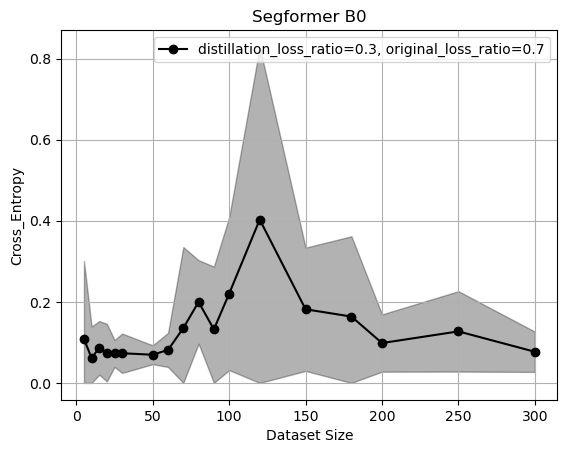

In [2]:
import os
import json

print("train_size size = ", np.array(train_sizes).size)
print("mean_val_losses size = ", np.array(mean_val_losses).size)
print("std_val_losses size = ", np.array(std_val_losses).size)
print("train_size = ", train_sizes)
print("mean_val_losses = ", mean_val_losses)
print("std_val_losses = ", std_val_losses)

results_dir = os.path.join(os.getcwd(), 'TrainingRecords', 'results_KD_segformer_0520')
if not os.path.exists(results_dir):
    os.makedirs(results_dir)

results = {
    "train_sizes": train_sizes,
    "mean_val_losses": mean_val_losses,
    "std_val_losses": std_val_losses
}
json_path = os.path.join(results_dir, f"results_KD_segformer_0520_{int(teacher_ratio*100)}.json")
with open(json_path, 'w') as json_file:
    json.dump(results, json_file, indent=4)

plt.figure()
plt.plot(train_sizes, mean_val_losses, marker='o', color='black', label=f'distillation_loss_ratio={teacher_ratio}, original_loss_ratio={round(1-teacher_ratio, 2)}')
plt.fill_between(train_sizes, np.maximum(0, np.array(mean_val_losses) - np.array(std_val_losses)), 
                 np.array(mean_val_losses) + np.array(std_val_losses), color='black', alpha=0.3)
plt.title('Segformer B0')
plt.xlabel('Dataset Size')
plt.ylabel('Cross_Entropy')
plt.grid(True)
plt.legend()
plt.savefig(os.path.join(results_dir, f"results_KD_segformer_0520_{int(teacher_ratio*100)}.png"))

plt.show()